In [1]:
# https://deeplearningcourses.com/c/unsupervised-deep-learning-in-python
# https://www.udemy.com/unsupervised-deep-learning-in-python
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

In [2]:
def relu(x):
    return x * (x > 0)


def error_rate(p, t):
    return np.mean(p != t)


def getKaggleMNIST():
    # MNIST data:
    # column 0 is labels
    # column 1-785 is data, with values 0 .. 255
    # total size of CSV: (42000, 1, 28, 28)
    train = pd.read_csv('us_data/train.csv').as_matrix().astype(np.float32)
    train = shuffle(train)

    Xtrain = train[:-1000,1:] / 255
    Ytrain = train[:-1000,0].astype(np.int32)

    Xtest  = train[-1000:,1:] / 255
    Ytest  = train[-1000:,0].astype(np.int32)
    return Xtrain, Ytrain, Xtest, Ytest


def init_weights(shape):
    return np.random.randn(*shape) / np.sqrt(sum(shape))

In [3]:
def purity(Y, R):
    # maximum purity is 1, higher is better

    N, K = R.shape
    p = 0
    for k in range(K):
        best_target = -1 # we don't strictly need to store this
        max_intersection = 0
        for j in range(K):
            intersection = R[Y==j, k].sum()
            if intersection > max_intersection:
                max_intersection = intersection
                best_target = j
        p += max_intersection
    return p / N

In [8]:
from scipy.stats import multivariate_normal


def gmm(X, K, max_iter=20, smoothing=10e-3):
    N, D = X.shape
    M = np.zeros((K, D))
    R = np.zeros((N, K))
    C = np.zeros((K, D, D))
    pi = np.ones(K) / K # uniform

    # initialize M to random, initialize C to spherical with variance 1
    for k in range(K):
        M[k] = X[np.random.choice(N)]
        C[k] = np.eye(D)

    costs = np.zeros(max_iter)
    weighted_pdfs = np.zeros((N, K)) # we'll use these to store the PDF value of sample n and Gaussian k
    for i in range(max_iter):
        # step 1: determine assignments / resposibilities
        for k in range(K):
            for n in range(N):
                weighted_pdfs[n,k] = pi[k]*multivariate_normal.pdf(X[n], M[k], C[k])

        for k in range(K):
            for n in range(N):
                R[n,k] = weighted_pdfs[n,k] / weighted_pdfs[n,:].sum()

        # a faster way to do step 1: "vectorization"
        # for k in xrange(K):
        #     weighted_pdfs[:,k] = pi[k]*multivariate_normal.pdf(X, M[k], C[k])
        # R = weighted_pdfs / weighted_pdfs.sum(axis=1, keepdims=True)

        # step 2: recalculate params
        for k in range(K):
            Nk = R[:,k].sum()
            pi[k] = Nk / N
            M[k] = R[:,k].dot(X) / Nk
            C[k] = np.sum(R[n,k]*np.outer(X[n] - M[k], X[n] - M[k]) for n in range(N)) / Nk + np.eye(D)*smoothing


        costs[i] = np.log(weighted_pdfs.sum(axis=1)).sum()
        if i > 0:
            if np.abs(costs[i] - costs[i-1]) < 0.1:
                break

    plt.plot(costs)
    plt.title("Costs")
    plt.show()

    random_colors = np.random.random((K, 3))
    colors = R.dot(random_colors)
    plt.scatter(X[:,0], X[:,1], c=colors)
    plt.show()

    print("pi:", pi)
    print("means:", M)
    print("covariances:", C)
    return R

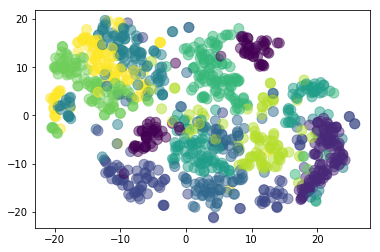

In [11]:
Xtrain, Ytrain, _, _ = getKaggleMNIST()

sample_size = 1000
X = Xtrain[:sample_size]
X = np.nan_to_num(X)
Y = Ytrain[:sample_size]
Y = np.nan_to_num(Y)

tsne = TSNE()
Z = tsne.fit_transform(X)
plt.scatter(Z[:,0], Z[:,1], s=100, c=Y, alpha=0.5)
plt.show()